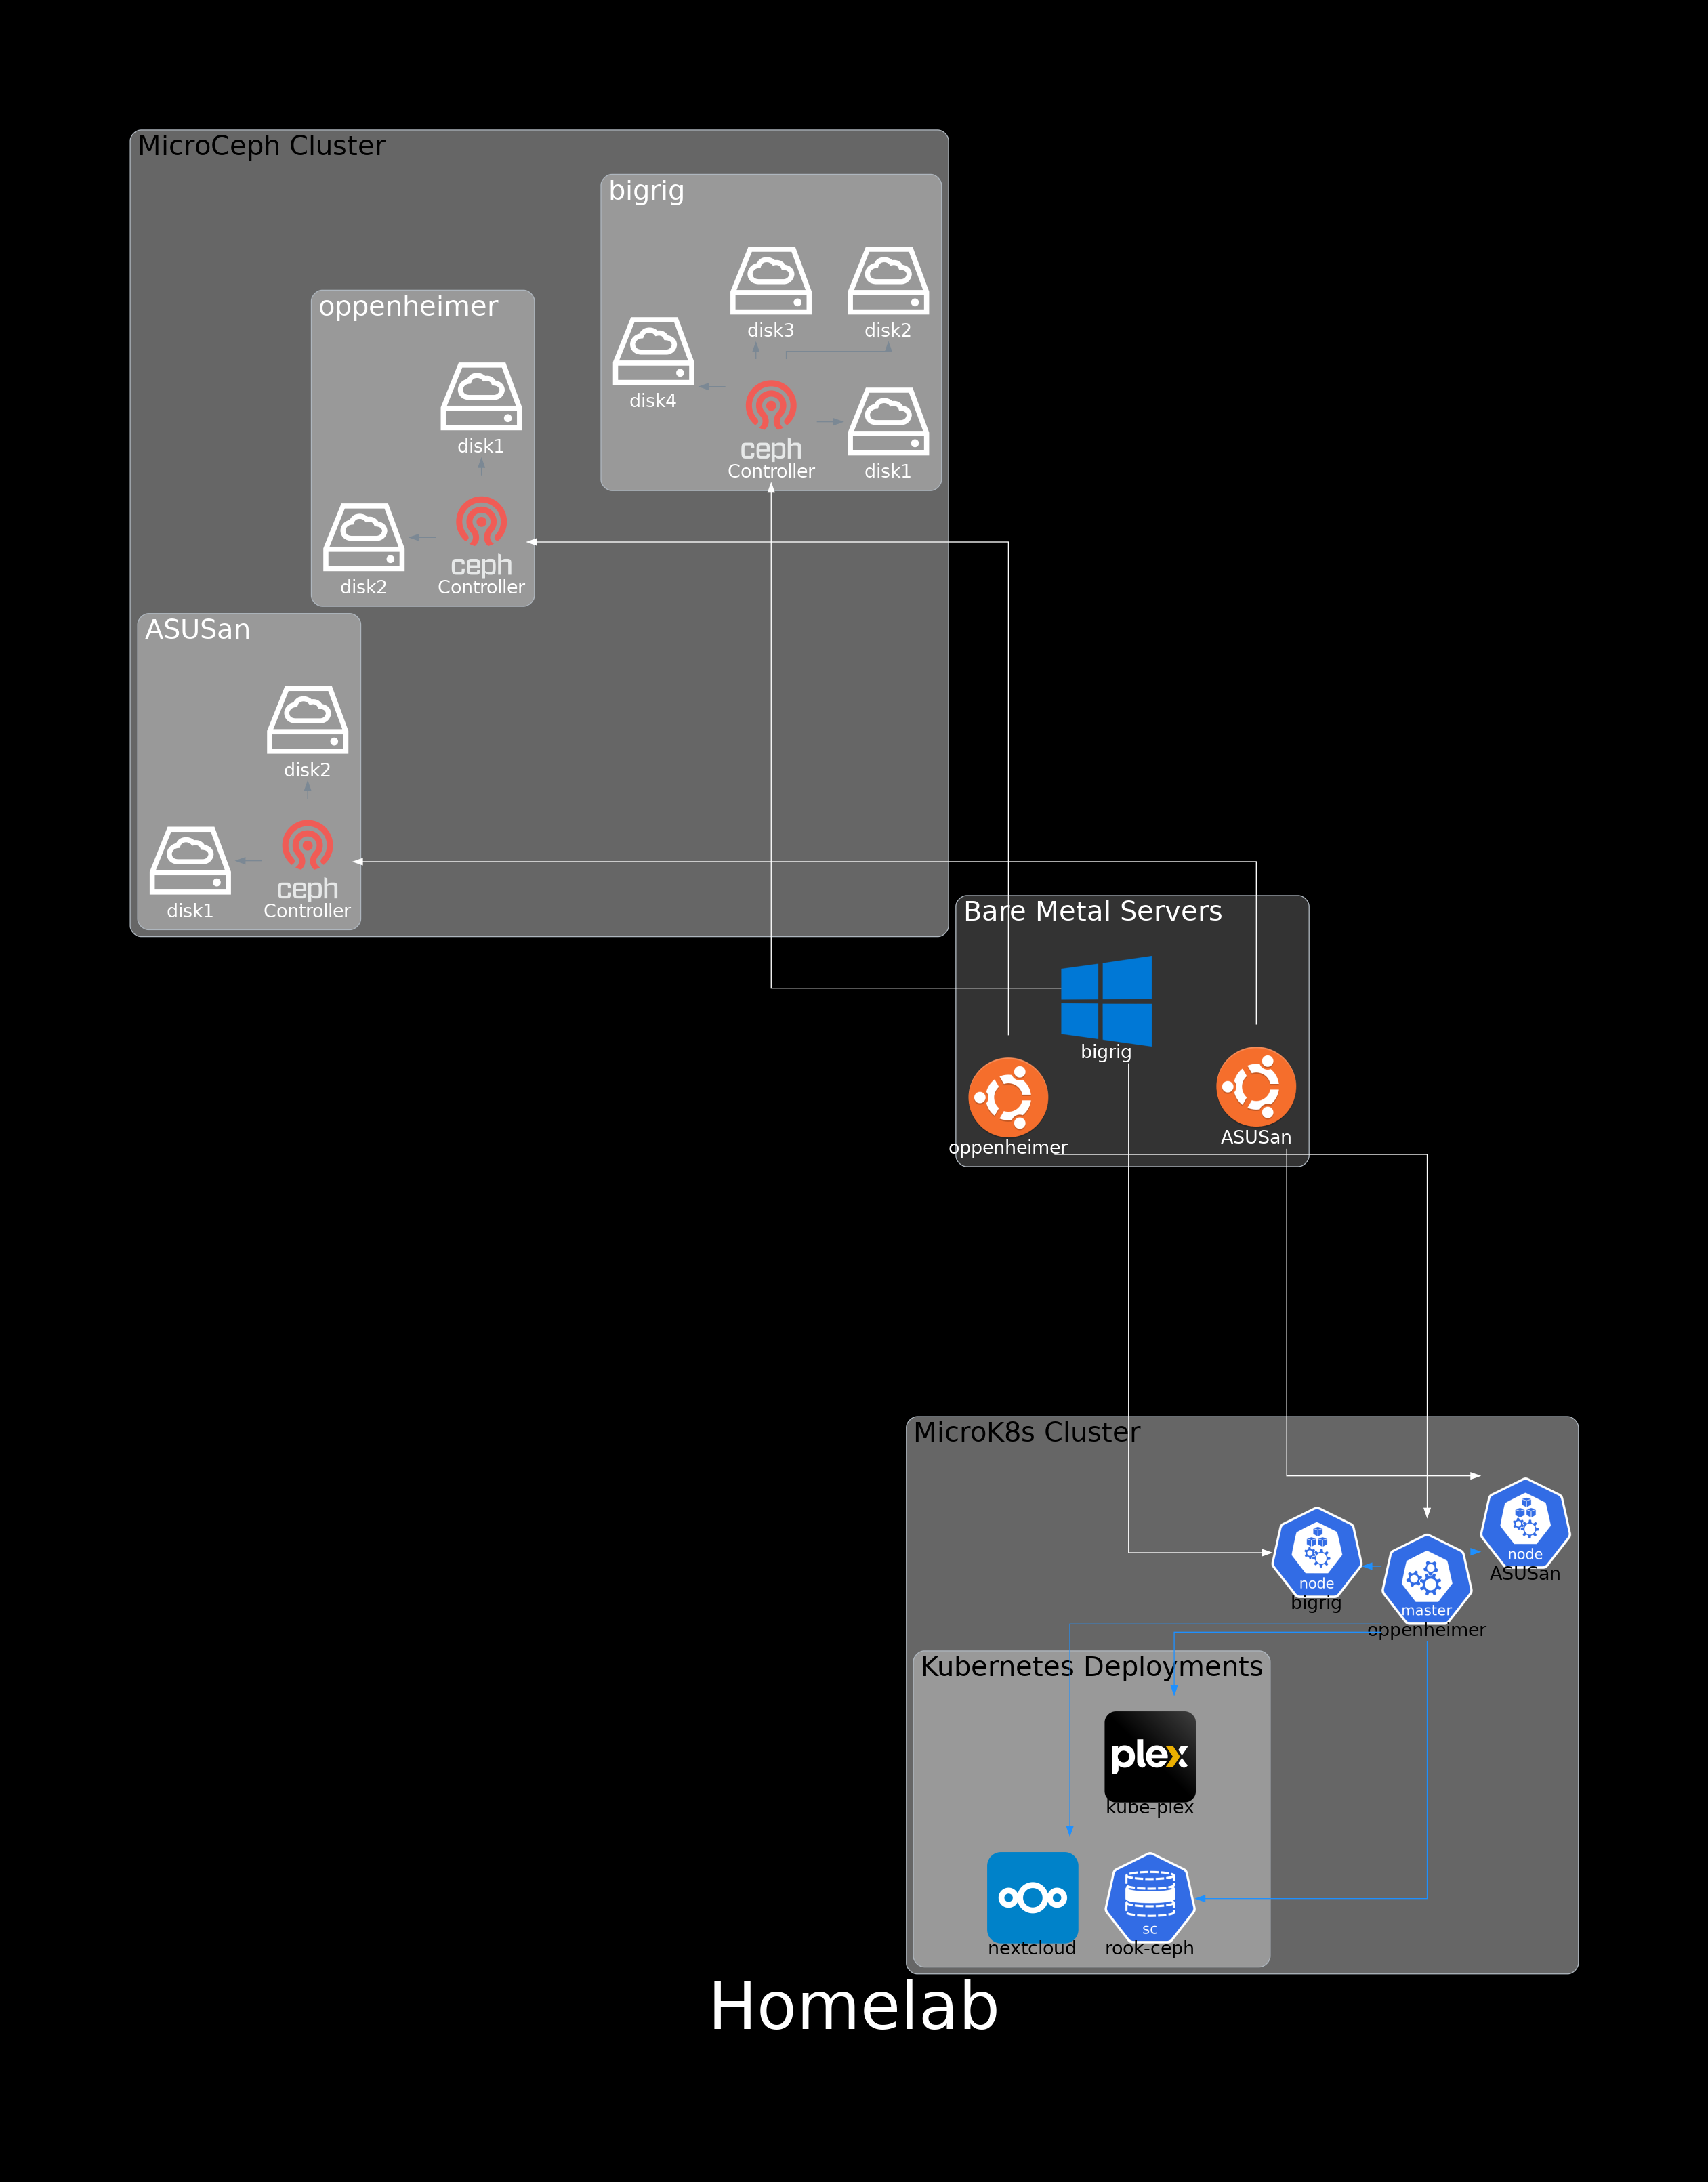

In [91]:
from diagrams               import Diagram, Cluster, Edge
from diagrams.custom        import Custom
from diagrams.generic.os    import Ubuntu, Windows
from diagrams.k8s.infra     import Master, Node
from diagrams.k8s.compute   import Deployment
from diagrams.k8s.storage   import StorageClass
from diagrams.oci.storage   import StorageGatewayWhite

diagram_attr = { "fontcolor": "white", "bgcolor": "black", "fontsize": "72", "layout": "fdp", "overlap": "false" }
with Diagram("Homelab", graph_attr=diagram_attr) as diag:
    ceph_cluster_attr = { "fontcolor": "black", "bgcolor": "gray40", "fontsize": "30" }
    with Cluster("MicroCeph Cluster", graph_attr=ceph_cluster_attr, direction="RL") as microceph:
        bigrig_ceph_attr = { "fontcolor": "white", "bgcolor": "gray60", "fontsize": "30" }
        with Cluster("bigrig", graph_attr=bigrig_ceph_attr) as bigrig_ceph:
            bigrig_ceph_node_attr = { "fontcolor": "white", "fontsize": "20" }
            bigrig_ceph_controller = Custom("Controller", "./custom_icons/ceph.png", **bigrig_ceph_node_attr)
            bigrig_ceph_disk1 = StorageGatewayWhite("disk1", **bigrig_ceph_node_attr)
            bigrig_ceph_disk2 = StorageGatewayWhite("disk2", **bigrig_ceph_node_attr)
            bigrig_ceph_disk3 = StorageGatewayWhite("disk3", **bigrig_ceph_node_attr)
            bigrig_ceph_disk4 = StorageGatewayWhite("disk4", **bigrig_ceph_node_attr)
            bigrig_ceph_disks = [bigrig_ceph_disk1, bigrig_ceph_disk2, bigrig_ceph_disk3, bigrig_ceph_disk4]
        
        oppenheimer_ceph_attr = { "fontcolor": "white", "bgcolor": "gray60", "fontsize": "30" }
        with Cluster("oppenheimer", graph_attr=oppenheimer_ceph_attr) as oppenheimer_ceph:
            oppenheimer_ceph_node_attr = { "fontcolor": "white", "fontsize": "20" }
            oppenheimer_ceph_controller = Custom("Controller", "./custom_icons/ceph.png", **oppenheimer_ceph_node_attr)
            oppenheimer_ceph_disk1 = StorageGatewayWhite("disk1", **oppenheimer_ceph_node_attr)
            oppenheimer_ceph_disk2 = StorageGatewayWhite("disk2", **oppenheimer_ceph_node_attr)
            oppenheimer_ceph_disks = [oppenheimer_ceph_disk1, oppenheimer_ceph_disk2]

        ASUSan_ceph_attr = { "fontcolor": "white", "bgcolor": "gray60", "fontsize": "30" }
        with Cluster("ASUSan", graph_attr=ASUSan_ceph_attr) as ASUSan_ceph:
            ASUSan_ceph_node_attr = { "fontcolor": "white", "fontsize": "20" }
            ASUSan_ceph_controller = Custom("Controller", "./custom_icons/ceph.png", **ASUSan_ceph_node_attr)
            ASUSan_ceph_disk1 = StorageGatewayWhite("disk1", **ASUSan_ceph_node_attr)
            ASUSan_ceph_disk2 = StorageGatewayWhite("disk2", **ASUSan_ceph_node_attr)
            ASUSan_ceph_disks = [ASUSan_ceph_disk1, ASUSan_ceph_disk2]

    baremetal_cluster_attr = { "fontcolor": "white", "bgcolor": "gray20", "fontsize": "30" }
    with Cluster("Bare Metal Servers", graph_attr=baremetal_cluster_attr) as baremetal_cluster:
        server_attr = { "fontcolor": "white", "fontsize": "20" }
        bigrig      = Windows("bigrig",     **server_attr)
        oppenheimer = Ubuntu("oppenheimer", **server_attr)
        ASUSan      = Ubuntu("ASUSan",      **server_attr)
        baremetal_servers = [oppenheimer, bigrig, ASUSan]

    k8s_cluster_attr = { "fontcolor": "black", "bgcolor": "gray40", "fontsize": "30" }
    with Cluster("MicroK8s Cluster", graph_attr=k8s_cluster_attr) as microk8s_cluster:
        k8s_node_attr = { "fontcolor": "black", "fontsize": "20" }
        master1 = Master("oppenheimer", **k8s_node_attr)
        node1   = Node("bigrig",        **k8s_node_attr)
        node2   = Node("ASUSan",        **k8s_node_attr)
        k8s_nodes = [master1, node1, node2]
        # k8s_nodes = [Master("oppenheimer", **k8s_node_attr), 
        #                 Node("bigrig",     **k8s_node_attr), 
        #                 Node("ASUSan",     **k8s_node_attr)]

        deploy_cluster_attr = { "bgcolor": "gray60", "fontsize": "30" }
        with Cluster("Kubernetes Deployments", graph_attr=deploy_cluster_attr) as k8s_deployments_cluster:
            deploy_node_attr = { "fontcolor": "black", "fontsize": "20" }
            kube_plex  = Custom("kube-plex", "./custom_icons/plex.png", **deploy_node_attr)
            nextcloud = Custom("nextcloud", "./custom_icons/nextcloud.png", **deploy_node_attr)
            rook_ceph = StorageClass("rook-ceph", **deploy_node_attr)

            k8s_deployments = [kube_plex, nextcloud, rook_ceph]

    # baremetal nodes to k8s nodes
    oppenheimer >> Edge(color="white") >> master1
    bigrig      >> Edge(color="white") >> node1
    ASUSan      >> Edge(color="white") >> node2
    # k8s nodes
    master1     >> Edge(color="dodgerblue") >> [node1, node2]
    master1     >> Edge(color="dodgerblue")  >> k8s_deployments
    # baremetal nodes to ceph nodes
    oppenheimer >> Edge(color="white") >> oppenheimer_ceph_controller >> oppenheimer_ceph_disks
    bigrig      >> Edge(color="white") >> bigrig_ceph_controller      >> bigrig_ceph_disks
    ASUSan      >> Edge(color="white") >> ASUSan_ceph_controller      >> ASUSan_ceph_disks

diag